In [1]:
import pysam
import deepchopper
from deepchopper import (
    remove_intervals_and_keep_left,
)
from deepchopper.utils import highlight_targets
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import logging
from rich.logging import RichHandler
from needletail import (
    parse_fastx_file,
    NeedletailError,
)

import seaborn as sns
import re
from textwrap import wrap
import gget

FORMAT = "%(message)s"
logging.basicConfig(
    level=logging.WARN,
    format=FORMAT,
    handlers=[RichHandler()],
)

INTERNAL_THRESHOLD: float = 0.9
OVERLAP_THRESHOLD: float = 0.4
BLAT_THRESHOLD: float = 0.9
MIN_MAPPING_QUALITY: int = 0


@dataclass
class FqRecord:
    id: str
    seq: str
    qual: str

    def to_str(self):
        return f"{self.id} {self.seq} {self.qual}"


def vis_qual_static(start: int | None = None, end: int | None = None, figure_size=(20, 1), seq=None):
    start = 0 if start is None else start
    end = len(predict.seq) if end is None else end

    qual = np.array([ord(c) - 33 for c in list(predict.qual[start:end])]).reshape(1, -1)
    seq = list(predict.seq[start:end])

    # Creating the heatmap
    fig, ax = plt.subplots(figsize=figure_size)  # Set a wide figure to accommodate the sequence
    cax = ax.imshow(qual, aspect="auto", cmap="viridis")
    cbar = plt.colorbar(cax, ax=ax, orientation="vertical")
    cbar.set_label("Value")
    # Setting up the sequence as x-axis labels
    ax.set_xticks(np.arange(len(seq)))
    ax.set_xticklabels(seq, rotation=90)  # Rotate labels for better readability
    # Remove y-axis labels as there's only one row
    ax.set_yticks([])
    ax.set_title(f"{predict.id}: {start}-{end}")
    plt.show()
    plt.close()


def to_fqs_record(predict, intervals: list[tuple[int, int]]):
    if predict.qual is None:
        raise ValueError("no qual, please fetch qual first")

    assert len(predict.qual) == len(predict.seq)

    seqs, saved_intervals = remove_intervals_and_keep_left(predict.seq, intervals)
    quals, saved_intervals = remove_intervals_and_keep_left(predict.qual, intervals)

    assert len(seqs) == len(quals)
    for ind, (seq, qual) in enumerate(zip(seqs, quals, strict=True)):
        record_id = f"@{predict.id}|{saved_intervals[ind][0], saved_intervals[ind][1]}"
        yield FqRecord(id=record_id, seq=seq, qual=qual)


def smooth_and_select_intervals(
    predict_id,
    stats,
    smooth_window_size: int,
    min_interval_length: int,
    approved_interval_nums: int = 1,
) -> list[tuple[int, int]]:
    chop_intervals = stats.smooth_intervals[predict_id]

    results = []
    for interval in chop_intervals:
        if interval[1] - interval[0] > min_interval_length:
            results.append(interval)

    if len(results) > approved_interval_nums:
        return []

    return results


def collect_fq_records(file: Path):
    result = {}
    try:
        for record in parse_fastx_file(file.as_posix()):
            result[record.id] = record
    except NeedletailError:
        print("Invalid Fastq file")

    return result


def collect_sam_records(file: Path):
    if not isinstance(file, Path):
        file = Path(file)

    result = {}
    samfile = pysam.AlignmentFile(file.as_posix(), "rb")

    for read in samfile.fetch():
        result[read.query_name] = read

    return result



def wrap_str(ostr, width):
    return "".join(wrap(ostr, width))


def show_sam_record(predict, stats, sam_records):
    seq_len = len(predict.seq)
    txt_width = 120

    print(f"read id {predict.id} seq len: {seq_len}")

    smooth_intervals = stats.smooth_intervals[predict.id]

    for interval in smooth_intervals:
        quals = predict.qual_array()[interval[0] : interval[1]]
        average_qual = sum(quals) / len(quals)
        print(f"smooth interval : {interval} len: {interval[1] - interval[0]} {average_qual=}")

    highlight_targets(predict.seq, predict.prediction_region())
    highlight_targets(predict.seq, smooth_intervals)

    predict_read = sam_records.get(predict.id, None)
    if predict_read is None:
        print("the read is not map")
        return

    if len(smooth_intervals) == 1:
        blat_df = gget.blat(predict.seq[smooth_intervals[0][0] : smooth_intervals[0][1]])
        if blat_df is not None:
            print(f"blat result: {blat_df.to_string()}")

    print(
        f"{predict_read.reference_id=} strand={'+' if predict_read.is_forward else '-'} {predict_read.mapping_quality=}"
    )
    print(f"{predict_read.reference_start=} {predict_read.reference_end=}")
    print(f"cigar: {wrap_str(predict_read.cigarstring, txt_width)}")

    ls_len, rs_len = deepchopper.left_right_soft_clip(predict_read.cigarstring)
    if not predict_read.is_forward:
        ls_len, rs_len = rs_len, ls_len

    print(f"ls: 0-{ls_len}  {wrap_str(predict.seq[:ls_len], txt_width)}")
    print(f"rs: {seq_len-rs_len}-{seq_len} {wrap_str(predict.seq[-rs_len:], txt_width)}")

    if predict_read.has_tag("SA"):
        print("has sa")
        chimeric_alns = predict_read.get_tag("SA")[:-1].split(";")

        for _aln in chimeric_alns:
            (
                chr_sa,
                pos_sa,
                strand_sa,
                cigar_sa,
                mapq_sa,
                nm_sa,
            ) = _aln.split(",")

            left_mat = pat_left_s.search(cigar_sa)
            right_mat = pat_right_s.search(cigar_sa)

            l_s_len = left_mat.group(1) if left_mat else ""
            r_s_len = right_mat.group(1) if right_mat else ""

            tgt_key = f"{predict_read.qname}	{l_s_len=}	{r_s_len=}"

            print(f"chimeric : {tgt_key}")


def check_overlap(
    interval1: tuple[int, int], interval2: tuple[int, int], overlap_threshold: float
) -> bool:
    # interval2 is predicted region

    start1, end1 = interval1
    start2, end2 = interval2

    length1 = end1 - start1
    length2 = end2 - start2

    # Calculate the maximum start point and minimum end point
    max_start = max(start1, start2)
    min_end = min(end1, end2)

    # union
    min_start = min(start1, start2)
    max_end = max(end1, end2)

    # Calculate the overlap length
    overlap = max(0, min_end - max_start)

    divide = length2

    ratio = overlap / divide

    # Check if the overlap meets or exceeds the threshold
    print(f"compare {interval1}({length1}) {interval2}({length2}) {ratio=}")
    return ratio >= overlap_threshold


def process_one_interval_parallel(
    overlap_results,
    whole_seq_len: int,
    pseq,
    pid,
    ls_len: int,
    rs_len: int,
    pd_start: int,
    pd_end: int,
    overlap_threshold: float,
    internal_threshold: float,
    blat_threshold: float,
    read_mp: int,
    min_mapping_quality: int,
):
    predict_seq = pseq[pd_start:pd_end]
    min_blat_seq_len = 20

    if pd_end / whole_seq_len > internal_threshold:
        # terminal adapter
        # has overlap
        if check_overlap(
            (whole_seq_len - rs_len, whole_seq_len),
            (pd_start, pd_end),
            overlap_threshold,
        ):
            overlap_results["terminal_chop_sc"].append(pid)
        else:
            overlap_results["terminal_chop_nosc"].append(pid)
            if len(predict_seq) < min_blat_seq_len:
                overlap_results["terminal_chop_nosc_cannot_blat"].append(pid)
                return

            blat_df = gget.blat(predict_seq)
            if blat_df is not None:
                print(f"blat_df: {blat_df.to_string()}")
            else:
                print("blat_df is None")

            if blat_df is None or (blat_df.iloc[0]["%_aligned"] / 100 < blat_threshold):
                overlap_results["terminal_chop_nosc_noblat"].append(pid)

    else:  # internal adapter
        flag = False
        if ls_len != 0:
            if check_overlap((0, ls_len), (pd_start, pd_end), overlap_threshold):
                flag = True
                overlap_results["internal_chop_sc"].append(pid)

        if rs_len != 0 and not flag:
            if check_overlap(
                (whole_seq_len - rs_len, whole_seq_len),
                (pd_start, pd_end),
                overlap_threshold,
            ):
                flag = True
                overlap_results["internal_chop_sc"].append(pid)

        if not flag:
            overlap_results["internal_chop_nosc"].append(pid)

            if len(predict_seq) < min_blat_seq_len:
                # seq is too short, and cannot use blat
                overlap_results["internal_chop_nosc_cannot_blat"].append(pid)
                return

            blat_df = gget.blat(predict_seq)
            if blat_df is not None:
                print(f"blat_df: {blat_df.to_string()}")
            else:
                print("blat_df is None")

            if blat_df is None or (blat_df.iloc[0]["%_aligned"] / 100 < blat_threshold):
                overlap_results["internal_chop_nosc_noblat"].append(pid)




def verify_result_with_sam_records_rs(
    overlap_results,
    predict,
    stats,
    rs_read,
    internal_threshold: float = INTERNAL_THRESHOLD,
    overlap_threshold: float = OVERLAP_THRESHOLD,
    blat_threshold: float = BLAT_THRESHOLD,
    min_mapping_quality: int = MIN_MAPPING_QUALITY,
):
    read_mapping_quality = rs_read.mapping_quality
    
    if not rs_read.is_mapped:
        print(f"the read {predict.id} is not map")
        overlap_results["unmap_read"].append(predict.id)
        return

    if read_mapping_quality < min_mapping_quality:
        print(f"the read {predict.id}'s mapping_quality {read_mapping_quality} is low")
        overlap_results["low_mp_read"].append(predict.id)
        return

    seq_len = len(predict.seq)

    ls_len, rs_len = rs_read.left_softclip, rs_read.right_softclip

    intervals = stats.smooth_intervals.get(predict.id, [])

    print("\n")
    print(predict.show_info(intervals))

    print(f"smooth intevals num: {len(intervals)}")

    txt_width = 120
    print(
        f"strand={'+' if rs_read.is_forward else '-'} {rs_read.mapping_quality=}"
    )
    # print(f"{predict_read.reference_start=} {predict_read.reference_end=}")
    print(f"cigar: {wrap_str(rs_read.cigar, txt_width)}")
    print(f"ls {ls_len}: 0-{ls_len}  {wrap_str(predict.seq[:ls_len], txt_width)}")
    print(f"rs {rs_len}: {seq_len-rs_len}-{seq_len} {wrap_str(predict.seq[seq_len-rs_len:seq_len], txt_width)}")
    

    if len(intervals) == 1:
        # clean predict
        start, end = intervals[0]
        # quals = predict.qual_array()[start:end]
        # average_qual = sum(quals) / len(quals)
        process_one_interval_parallel(
            overlap_results,
            seq_len,
            predict.seq,
            predict.id,
            ls_len,
            rs_len,
            start,
            end,
            overlap_threshold,
            internal_threshold,
            blat_threshold,
            read_mapping_quality,
            min_mapping_quality,
        )
    elif len(intervals) <= 3:
        for interval in intervals:
            start, end = interval
            process_one_interval_parallel(
                overlap_results,
                seq_len,
                predict.seq,
                predict.id,
                ls_len,
                rs_len,
                start,
                end,
                overlap_threshold,
                internal_threshold,
                blat_threshold,
                read_mapping_quality,
                min_mapping_quality,
            )
    else:
        overlap_results["no_process"].append(predict.id)
        pass



from collections import defaultdict


def verify_result_with_sam_records_for_parallel(
    pseq: str,
    pid: str,
    smooth_intervals: dict[str, list[tuple[int, int]]],
    read_is_mapped: bool,
    read_mapping_quality: int,
    read_left_softclip: int,
    read_right_softclip: int,
    internal_threshold: float = INTERNAL_THRESHOLD,
    overlap_threshold: float = OVERLAP_THRESHOLD,
    blat_threshold: float = BLAT_THRESHOLD,
    min_mapping_quality: int = MIN_MAPPING_QUALITY,
):
    overlap_results = defaultdict(list)
    read_mapping_quality = read_mapping_quality

    if not read_is_mapped:
        print(f"the read {pid} is not map")
        overlap_results["unmap_read"].append(pid)
        return overlap_results

    if read_mapping_quality < min_mapping_quality:
        print(f"sthe read {pid}'s mapping_quality {read_mapping_quality} is low")
        overlap_results["low_mp_read"].append(pid)
        return overlap_results

    seq_len = len(pseq)
    ls_len, rs_len = read_left_softclip, read_right_softclip
    intervals = smooth_intervals[pid]

    if len(intervals) == 1:
        # clean predict
        start, end = intervals[0]
        
        process_one_interval_parallel(
            overlap_results,
            seq_len,
            pseq,
            pid,
            ls_len,
            rs_len,
            start,
            end,
            overlap_threshold,
            internal_threshold,
            blat_threshold,
            read_mapping_quality,
            min_mapping_quality,
        )
    elif len(intervals) <= 3:
        for interval in intervals:
            start, end = interval
            process_one_interval_parallel(
                overlap_results,
                seq_len,
                pseq,
                pid,
                ls_len,
                rs_len,
                start,
                end,
                overlap_threshold,
                internal_threshold,
                blat_threshold,
                read_mapping_quality,
                min_mapping_quality,
            )
    else:
        overlap_results["no_process"].append(pid)
        
    return overlap_results


def merge_results(results_list):
    combined_results = defaultdict(list)
    for single_result in results_list:
        for key, values in single_result.items():
            combined_results[key].extend(values)
    return combined_results

In [2]:
import pysam
import deepchopper
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textwrap import wrap
import matplotlib as mpl

def get_acc(data):
    internal_chop_sc_count = len(data.get("internal_chop_sc", []))
    internal_chop_nosc_count = len(data.get("internal_chop_nosc", []))
    internal_chop_nosc_noblat_count = len(data.get("internal_chop_nosc_noblat", []))
    internal_chop_nosc_cannotblat_count = len(data.get("internal_chop_nosc_cannot_blat", []))
    total_internal = internal_chop_sc_count + internal_chop_nosc_count
    confirmed_internal = internal_chop_sc_count + internal_chop_nosc_noblat_count

    internal_acc = confirmed_internal / (total_internal)

    terminal_chop_sc_count = len(data.get("terminal_chop_sc", []))
    terminal_chop_nosc_count = len(data.get("terminal_chop_nosc", []))
    terminal_chop_nosc_noblat_count = len(data.get("terminal_chop_nosc_noblat", []))
    terminal_chop_nosc_cannotblat_count = len(data.get("terminal_chop_nosc_cannot_blat", []))
    total_terminal = terminal_chop_sc_count + terminal_chop_nosc_count
    confirmed_terminal = terminal_chop_sc_count + terminal_chop_nosc_noblat_count

    terminal_acc = confirmed_terminal / (total_terminal)

    total_acc = (confirmed_internal + confirmed_terminal) / (total_internal + total_terminal)

    return internal_acc, terminal_acc, total_acc



In [3]:
print("done")

done


In [4]:
import deepchopper
import json

# right Softclip diff

In [5]:
import pysam
dc_chop_samfile = pysam.AlignmentFile("/projects/b1171/ylk4626/project/DeepChopper/vcap_all.9177639pd.chop.bam", "rb")
do_chop_sam_file=  pysam.AlignmentFile("/projects/b1171/ylk4626/project/DeepChopper/dorado_trim.fastq.bam", "rb")

In [6]:
dc_chop_record =  {i.query_name : i   for i in dc_chop_samfile.fetch()}

In [13]:
do_chop_record = {i.query_name : i  for i in do_chop_sam_file.fetch()}

In [17]:
def print_pysam_record(record):
    print(f"{record.query_name=} {record.mapping_quality=} {'+' if record.is_forward else '-'}")
    print(f"{record.is_mapped=} primary: {not record.is_secondary}")
    print(f"{record.cigarstring=}")
    print(f"len {len(record.query_sequence)} {record.query_sequence=}")
    print(f"{record.reference_name=} {record.reference_start=} {record.reference_end=}")


In [18]:
cpname = '902e0718-fed9-4973-b8c9-0a461173408c|0:5900|T'

print_pysam_record(dc_chop_record[cpname])
print('\n')
print_pysam_record(do_chop_record[cpname.split("|")[0]])

record.query_name='902e0718-fed9-4973-b8c9-0a461173408c|0:5900|T' record.mapping_quality=60 +
record.is_mapped=True primary: True
record.cigarstring='380S53M1I46M1I28M3I100M2I18M6397N5M1D1M1D4M3I51M2D2M2D15M2D4M616N54M4I123M1I3M1I13M3D18M3D24M1I62M2D65M1D106M3D17M1I2M1I2M1I34M1I31M4929N73M1D47M1525N35M2D15M1D22M684N87M1003N4M2D165M1I8M1I14M1681N156M1I6M1I12M395N152M1247N117M1I38M1I4M1I4M3D4310N34M1I18M1I113M2036N93M1983N26M2I35M1I167M476N128M1894N17M1I45M1I52M1D1M1D23M1I44M6D37M2I25M1D27M3I18M1I124M2D27M1I9M1I50M1D56M1I5M1I5M1D92M1I9M1D12M2D8M1I21M1I25M2D131M1D23M3I7M1I66M1D56M2D51M1D10M1I71M1I40M1D98M1I19M1D73M1D36M1D66M1I41M1D39M4D5M3I51M1D10M1D94M1D46M1I6M1D14M1I163M1D41M2I37M1D94M1I19M1D19M1D43M1D14M2I46M1D9M1I5M1I69M1D37M1D101M1I131M3D189M1I48M1D95M1I21M1D9M1D12M7S'
len 5900 record.query_sequence='GCTCGCGGCAGCTCCCCGTGGAGGTCACTGTCCGTGCCAGTCCCTCCCGCTGTCCCGCCCTCTCCCGCTGCCGCCGCCGCCGCCGCCGCGCCCGCCTCAGCGCCCCCACTCCGCGCTTGGGAGCGAGGAGCCGCAGCGCCCCCGCCCCCGCCGCCGCCAGCGCCCTCAGGCCGCCATTCGCCACCG

In [5]:
right_softclip_diff_path = "/projects/b1171/ylk4626/project/DeepChopper/terminal_right_softclip_diff.json"
right_softclip_diff_results = json.load(open(right_softclip_diff_path))

In [6]:
len(right_softclip_diff_results)

7333668

In [8]:
max(right_softclip_diff_results.values())

2891

In [9]:
min(right_softclip_diff_results.values())

-3049

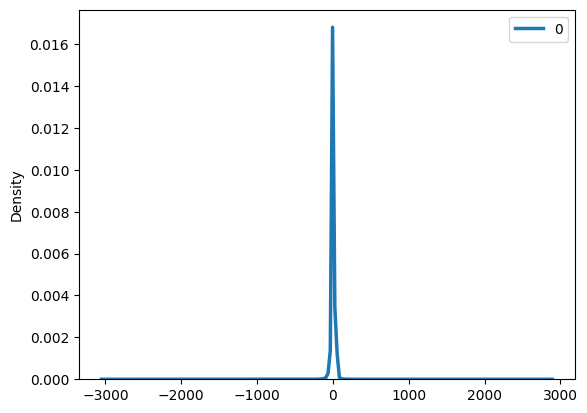

In [10]:
ax = sns.kdeplot(right_softclip_diff_results.values(), color='deepskyblue', linestyle='-', linewidth=2.5)
# plt.yscale('log')

<Axes: ylabel='Density'>

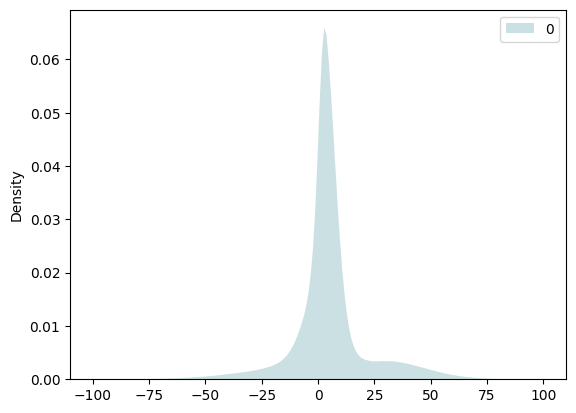

In [14]:
# fill=True, common_norm=False, palette="crest",
#    alpha=.5, linewidth=0,
sns.kdeplot(right_softclip_diff_results.values(), palette="crest", linestyle='-', linewidth=0, fill=True,  clip=(-100, 100))

In [40]:
large_than_0_values = np.array([i for i in right_softclip_diff_results.values()  if i > 0])
large_than_0 = len(large_than_0_values)

In [41]:
small_than_0_values = np.array([i for i in right_softclip_diff_results.values()  if i < 0])
small_than_0 = len(small_than_0_values)

In [42]:
equal_0_values = np.array([i for i in right_softclip_diff_results.values()  if i == 0])
equal_0 = len(equal_0_values)

In [19]:
large_than_0

5077436

In [22]:
small_than_0

1904970

In [45]:
hs2 = sns.violinplot(x = ["L0", "S0", "E0" ], y=[large_than_0_values, small_than_0_values, equal_0_values])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

[Text(0, 0, '5.07744e+06'), Text(0, 0, '1.90497e+06'), Text(0, 0, '351262')]

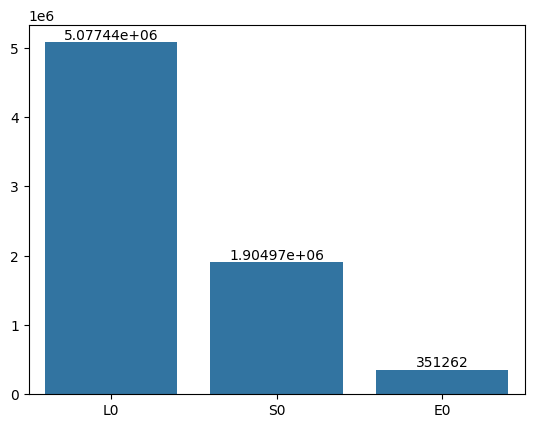

In [34]:
hs = sns.barplot(x = ["L0", "S0", "E0" ], y=[large_than_0, small_than_0, len(right_softclip_diff_results) - large_than_0 - small_than_0])
hs.bar_label(hs.containers[0], fontsize=10)

In [11]:
sns.histplot(right_softclip_diff_results.values())
# plt.yscale('log')

<Axes: ylabel='Count'>

Error in callback <function flush_figures at 0x2b00c7816320> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



# Compare len with or without dorado

In [26]:
cmp_len_path = "/projects/b1171/ylk4626/project/DeepChopper/compare_len.json"
cmp_len_results = json.load(open(cmp_len_path))

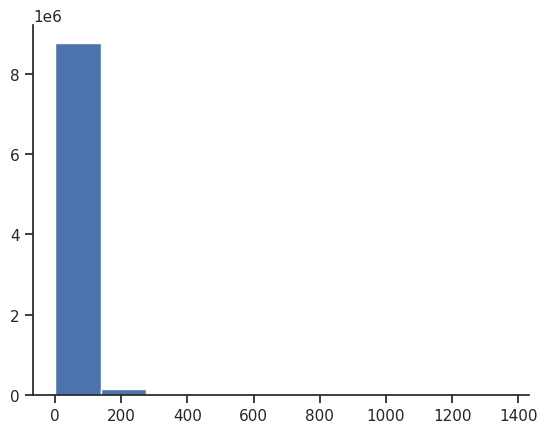

In [57]:
sns.set_theme(style="ticks")
# sns.kdeplot(cmp_len_results.values(), fill=True)
plt.hist(cmp_len_results.values(), fill=True)
# ax = sns.histplot(cmp_len_results.values(),fill=True)
# ax.bar_label(ax.containers[0], fontsize=10)
sns.despine()
# plt.xticks(range(0, 1500, 50), rotation=45, ha="right")

In [24]:
len(cmp_len_results)

8931897

In [47]:
pids_cmp_length_large = []
for k, v in cmp_len_results.items():
    if v > 1000:
        if k in dorado_with_trim and k in dorado_with_trim:
            pids_cmp_length_large.append(k)

In [48]:
len(pids_cmp_length_large)

11

In [10]:
def load_fq_record(file):
    result = {}
    for record in parse_fastx_file(file):
        result[record.id] = record
    return result

In [11]:
%%time
dorado_without_trim = load_fq_record("/projects/b1171/ylk4626/project/DeepChopper/data/dorado_without_trim_fqs/VCaP.fastq")

CPU times: user 28.7 s, sys: 11.1 s, total: 39.8 s
Wall time: 40.1 s


In [12]:
%%time
dorado_with_trim = load_fq_record("/projects/b1171/ylk4626/project/DeepChopper/data/real_ont_data_no_trim/VCaP/dorado_analysis/fastq/raw.fastq")

CPU times: user 27.6 s, sys: 10.6 s, total: 38.2 s
Wall time: 38.4 s


In [13]:
len(dorado_without_trim)

9177639

In [14]:
len(dorado_with_trim)

9177422

In [17]:
diff1 = list(set(dorado_without_trim)  - set(dorado_with_trim))

In [18]:
len(diff1)

247

In [15]:
tres = []
for k in :
    tres.append(len(dorado_without_trim[k].seq))
    

(array([77., 29., 13., 11., 27., 49., 28.,  7.,  4.,  2.]),
 array([  5. ,  17.5,  30. ,  42.5,  55. ,  67.5,  80. ,  92.5, 105. ,
        117.5, 130. ]),
 <BarContainer object of 10 artists>)

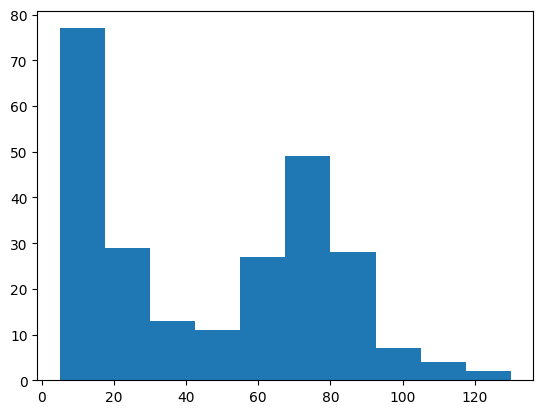

In [19]:
plt.hist(tres)

In [33]:
def vis_cmp_len_by_upset_plot(dorado_without_trim,dorado_with_trim ):
    from matplotlib import pyplot as plt
    import pandas as pd
    from upsetplot import plot
    
    # Assuming 'dorado_without_trim' and 'dorado_with_trim' are lists or sets of your data
    data = {
        'Dorado Without Trim': set(dorado_without_trim),
        'Dorado With Trim': set(dorado_with_trim)
    }
    
    # Convert the sets into a DataFrame suitable for upset plotting
    from collections import Counter
    
    # Find the intersection and unique items
    all_items = set(dorado_without_trim) | set(dorado_with_trim)
    counts = Counter(
        (item in data['Dorado Without Trim'], item in data['Dorado With Trim'])
        for item in all_items
    )
    
    # Transform counters to a DataFrame
    index = pd.MultiIndex.from_tuples(
        [idx for idx in counts.keys()],
        names=['Dorado Without Trim', 'Dorado With Trim']
    )
    upset_data = pd.Series(list(counts.values()), index=index)
    
    # Plot
    plot(upset_data, show_counts='%d')

/projects/b1171/ylk4626/mambaforge/envs/deepchopper/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/projects/b1171/ylk4626/mambaforge/envs/deepchopper/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermed

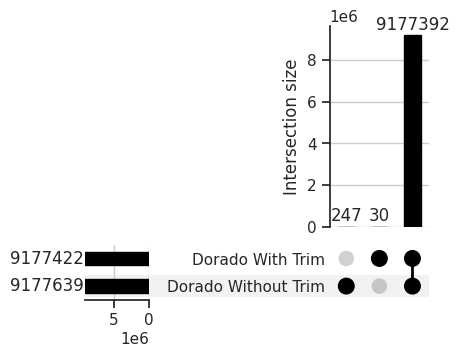

In [34]:
vis_cmp_len_by_upset_plot(dorado_without_trim, dorado_with_trim)

In [30]:
import stringzilla as sz

In [20]:
idx = 0
pds = ['5524b3f8-47bd-4396-b15b-d780bc487c81']
# pids_cmp_length_large
for pd in pds:
    idx +=1 
    with_trim = dorado_with_trim[pd].seq
    without_trim = dorado_without_trim[pd].seq
    print(f"\nid{dorado_without_trim[pd].id}")
    print(f"without trim {len(without_trim)}: {without_trim}")
    print(f"with trim    {len(with_trim)}   : {with_trim}")
    dis  = sz.edit_distance(with_trim, without_trim)
    print(f"distance {dis}")
    if idx >= 10:
        break

NameError: name 'dorado_with_trim' is not defined

In [59]:
idx = 0
for key, diff in cmp_len_results.items():
    idx +=1 
    with_trim = dorado_with_trim[key].seq
    without_trim = dorado_without_trim[key].seq
    print(f"\nid{dorado_without_trim[key].id} {diff=}")
    print(f"without trim {len(without_trim)}: {without_trim}")
    print(f"with trim    {len(with_trim)}   : {with_trim}")
    dis  = sz.edit_distance(with_trim, without_trim)
    print(f"distance {dis}")
    if idx >= 50:
        break


iddec24e57-3b76-46e2-ad25-df36879cccaa diff=58
without trim 615: TCAGGCGGCCGGGAAGATGGCGGACATTCAGACTGAGCGTGCCTACCAAAAGCAGCCGACCATTCTTTCAAAACAAGAAGAGGGTCCTGCTGGGAGAAACTGGCAAGGAGAAGCTCCCGCAGTTTACAAGATTACCGGTCTGGGCTTCAAGACACCCAAGGAGGCTATTGGGGCACCTACATTGACAAGAAATGCCCCTTCACTGGTAATGTGTCCATTCGAGGGTGGATCCTCTCTGGCGTGGTGACCAAGATGAAGATGCAGAGGACCATTGTCATCCGCCGAGACTATCTGCACTACATCCGCAAGTACAACCGCTTCGAGAAGCGCCACAAGAACATGTCTGTACACCTGTCCCCTGCTTCAGGGACGCCAGATCGGTGACCGTACACAGTGGGCGAGTGCCGGCCTCTGAGCAAGACAGTGCCTCAACGTGCTCAAGGTCACCAAGGCTGCCGGCACCAAGAAGCAGTTCAGAAGTCTGAGGCTGGACATCGGCCCGCTCCCCACAATGAATAAAGTTATTTTCTCATTCCCAAAAAAAATCCCCTCCCTCCCATCCTCCCTCTCTCCCACCAATCATCATCCATATCATCCCACCATCCTAATTCTCCC
with trim    557   : TCAGGCGGCCGGGAAGATGGCGGACATTCAGACTGAGCGTGCCTACCAAAAGCAGCCGACCATTCTTTCAAAACAAGAAGAGGGTCCTGCTGGGAGAAACTGGCAAGGAGAAGCTCCCGCAGTTTACAAAGATTACCGGTCTGGGCTTCAAGACACCCAAGGAGGCTATTGGGGCACCTACATTGACAAGAAATGCCCCTTCACTGGTAATGTGTCCATTCGAGGGTGGATCCTCTCTGGCGTGGTGACCAAGATGAAGATGCAGAGGACCATTGTCATCCGCCGAGACTATCTGCA

In [44]:
blat_predicts_json_path = "/projects/b1171/ylk4626/project/DeepChopper/blat_all_predicts_blat_identities.json"
blat_predicts =  json.load(open(blat_predicts_json_path))

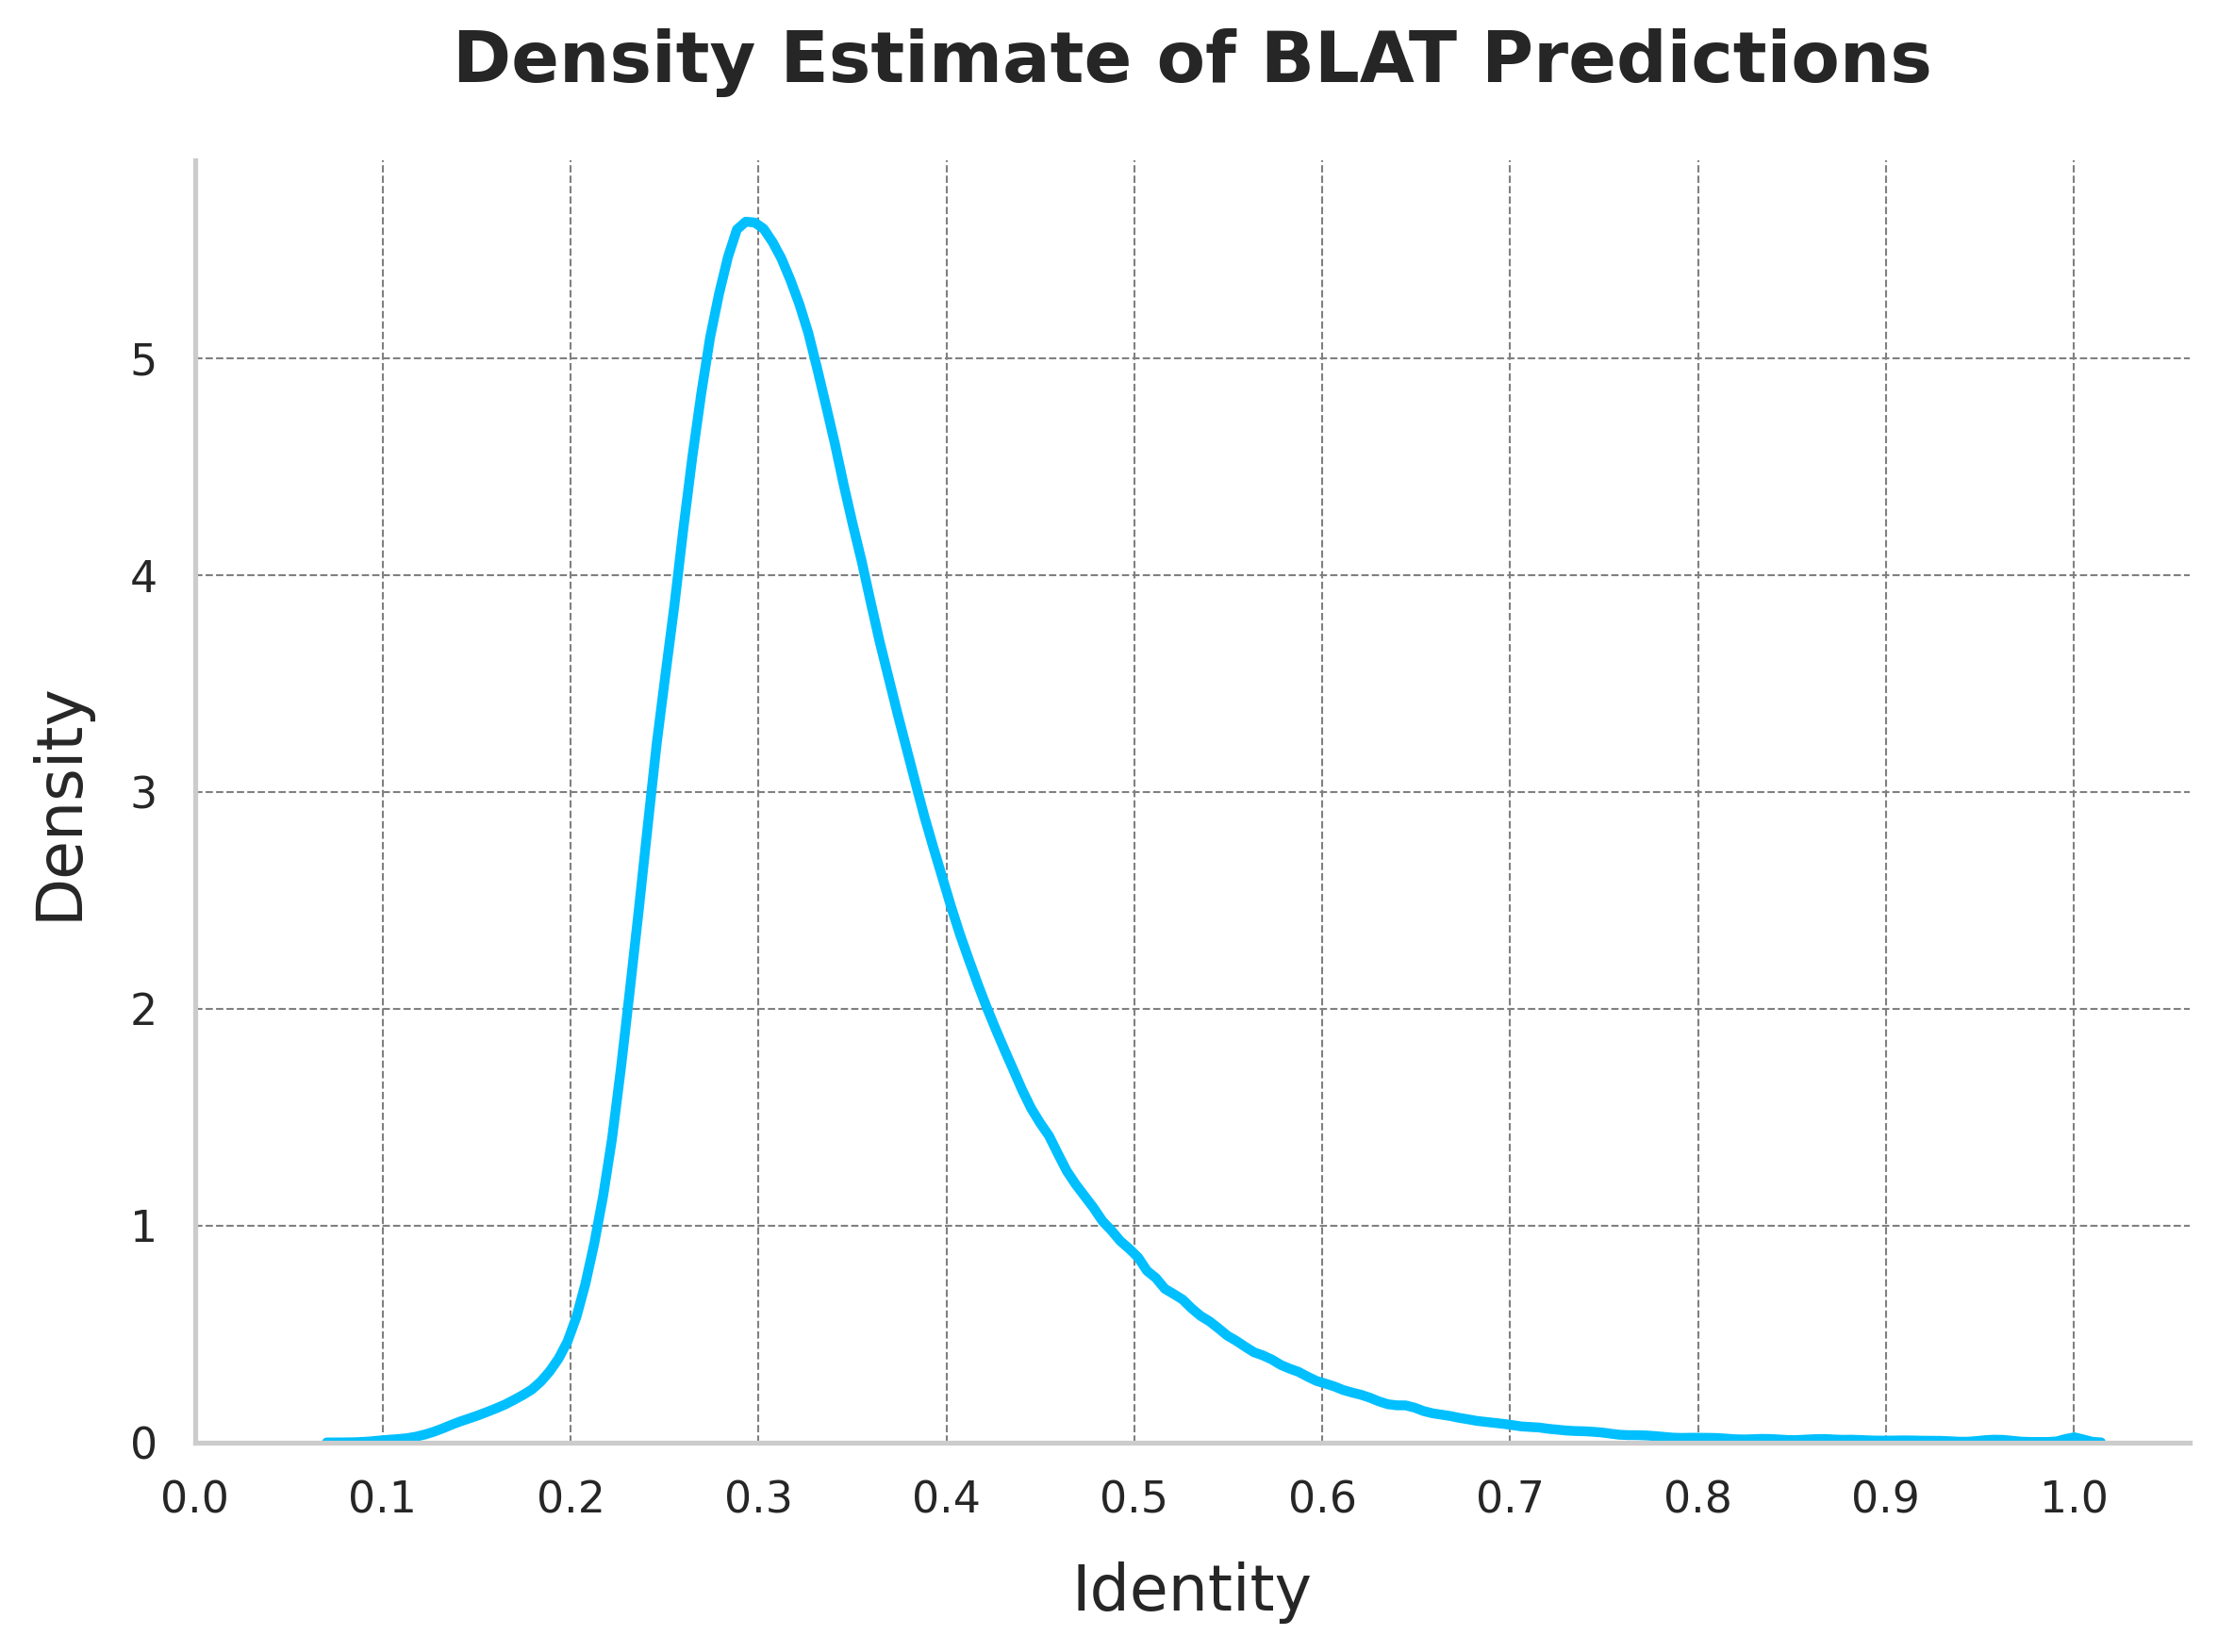

In [64]:
# Set a high-resolution figure for publication
plt.figure(figsize=(8, 6), dpi=300)

# Apply a style
sns.set(style="whitegrid", palette="muted", font_scale=1)

# Create the plot
ax = sns.kdeplot(blat_predicts, color='deepskyblue', linestyle='-', linewidth=2.5)
ax.set_title('Density Estimate of BLAT Predictions', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Identity', fontsize=16, labelpad=10)
ax.set_ylabel('Density', fontsize=16, labelpad=10)

plt.xticks(np.arange(0, 1.1, 0.1))

# Uncomment below to set the y-axis to log scale
# plt.yscale('log')
# plt.gca().yaxis.set_major_formatter(LogFormatter())

# Fine-tune the grid and axes for better readability
plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='grey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tight layout often provides a cleaner look
plt.tight_layout()

# Save the plot as a high-resolution PNG file
# plt.savefig('blat_predictions_density.pdf', format='pdf', dpi=300)


# Stat and Overlap Analysis

In [27]:
stats_json_path = "/projects/b1171/ylk4626/project/DeepChopper/stats_pd1000000_bt0.json"
stats = deepchopper.StatResult.from_json(stats_json_path)

In [9]:
overlap_result_path = "/projects/b1171/ylk4626/project/DeepChopper/overlap_results_spd27531_pd32000.json"
overlap_results = json.load(open(overlap_result_path))

In [11]:
overlap_results.keys()

dict_keys(['unmapped_read', 'internal_chop_nosc_noblat', 'internal_chop_nosc_cannot_blat', 'internal_chop_sc_sa', 'terminal_chop_sc', 'sc_without_chop)', 'internal_chop_nosc', 'terminal_chop_nosc_cannot_blat', 'internal_chop_sc', 'terminal_chop_nosc', 'terminal_chop_nosc_noblat'])

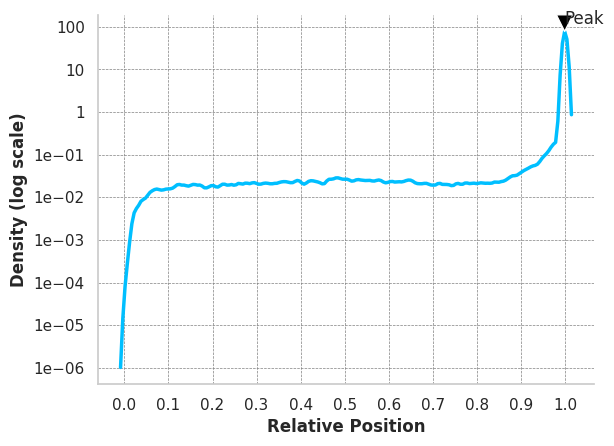

In [66]:
from matplotlib.ticker import LogFormatter

# Set style
# sns.set(style="darkgrid")
sns.set(style="whitegrid", palette="muted", font_scale=1)

# Create the plot
kde = sns.kdeplot(stats.smooth_intervals_relative_pos, color='deepskyblue', linestyle='-', linewidth=2.5)
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(LogFormatter())

plt.xticks(np.arange(0, 1.1, 0.1))
# Set labels and title
plt.xlabel('Relative Position', fontsize=12, fontweight='bold')
plt.ylabel('Density (log scale)', fontsize=12, fontweight='bold')
# plt.title('Kernel Density Estimate on Log Scale', fontsize=14, fontweight='bold')

# Calculate peak position and value
x, y = kde.get_lines()[0].get_data()
peak_index = np.argmax(y)
peak_pos, peak_value = x[peak_index], y[peak_index]

# Annotate peak
plt.annotate('Peak', xy=(peak_pos, peak_value), xytext=(peak_pos, peak_value * 1.5),
             arrowprops=dict(facecolor='black', shrink=0.05))


plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='grey') 
sns.despine()

In [15]:
def vis_stats(stats, total: int, figsize=(10, 6), save=False, log=False, context="notebook"):
    # Extracting data for plotting
    # sns.set_context(context)
    sns.set_theme(style="ticks")
    categories = [
        "Total Predicts",
        "Total Truncated",
        "Predicts with Chop",
        "Smooth Predicts with Chop",
        "Smooth Internal Predicts",
        "Smooth Only One",
        "Smooth Polya Only One",
    ]
    values = [
        stats.total_predicts,
        stats.total_truncated,
        len(stats.predicts_with_chop),
        len(stats.smooth_predicts_with_chop),
        len(stats.smooth_internal_predicts),
        len(stats.smooth_only_one),
        len(stats.smooth_only_one_with_ploya),
    ]
    
    # Creating the bar plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=categories, y=values, log_scale=log)
    ax.bar_label(ax.containers[0], fontsize=10);

    plt.xlabel("Categories")
    plt.ylabel("Count")
    plt.title(f"Statistics for {total}")
    plt.xticks(rotation=45, ha="right")  # Rotate category names for better visibility
    plt.tight_layout()  # Adjust layout to make all labels visible
    sns.despine()

    if save:
        plt.savefig("stats.pdf", dpi=300)

    plt.show()

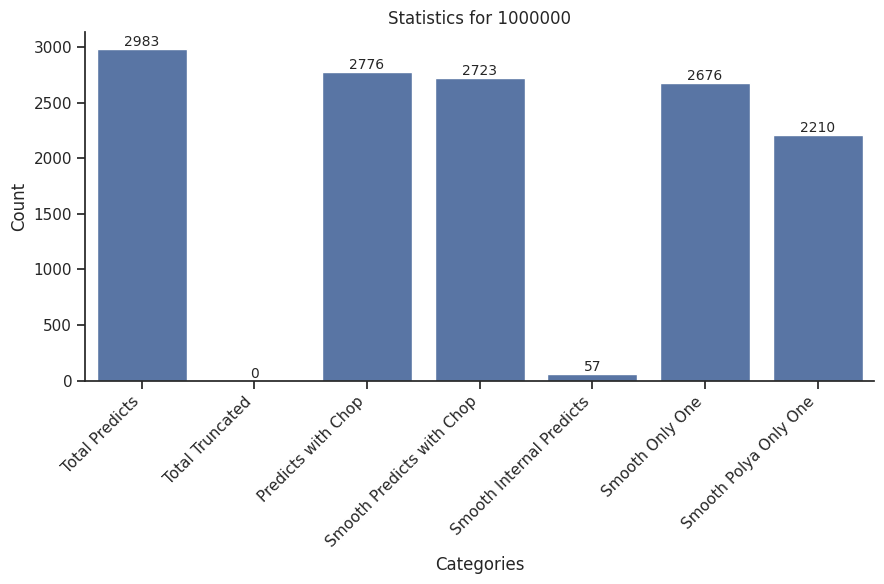

In [16]:
vis_stats(stats, 1000000, (9,6), save=False, log=False)

In [60]:
def vis_hist_for_num_of_intervals(data, figsize=(10, 6), title=None, ax=None, set_xticks=False, log=False, kde=False):
    # Create histogram with a kernel density estimate
    # sns.set_context(context)
    sns.set_theme(style="ticks")
    max_x = max(data) + 1
    if ax is None:
        plt.figure(figsize=figsize)
        sns.histplot(data, kde=kde,  
                     log_scale=log)
        if set_xticks:
            plt.xticks(range(0, max_x, 1))
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        sns.histplot(
            data,
            kde=kde,
            # color="#66c2a5",
            # line_kws={"linewidth": 2},
            # discrete=True,
            ax=ax,
            log_scale=log
        )
        ax.set_title(title)
        if set_xticks:
            ax.set_xticks(range(0, max_x, 1))
        ax.set_xlabel("The Number of Intervals Per Predict")
        ax.set_ylabel("Frequency")
    sns.despine()


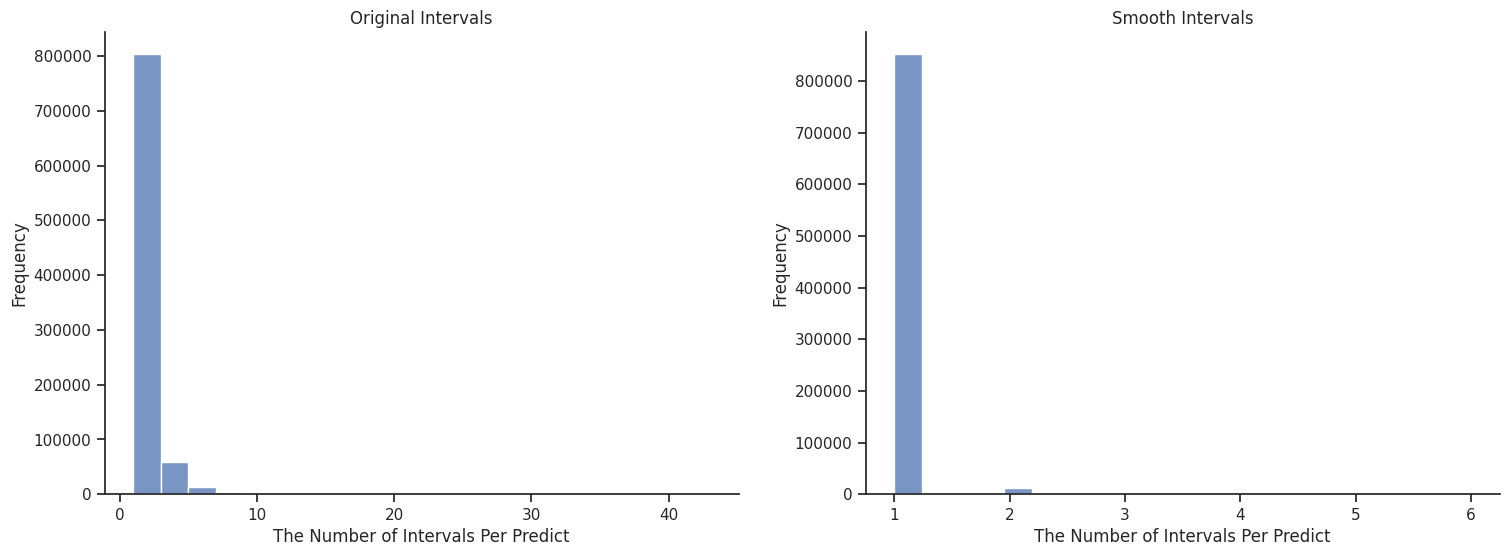

In [61]:
original_prediction_number = stats.number_predicts_with_chop()
smooth_prediction_number = stats.number_smooth_predicts_with_chop()

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals(original_prediction_number, title="Original Intervals", ax=axs[0])
vis_hist_for_num_of_intervals(smooth_prediction_number, title="Smooth Intervals", ax=axs[1])

In [23]:
def vis_hist_for_num_of_intervals2(data, figsize=(10, 6), title=None, ax=None, set_xticks=False):
    # Create histogram with a kernel density estimate
    max_x = max(data) + 1
    sns.set_theme(style="ticks")
    if ax is None:
        plt.figure(figsize=figsize)
        sns.kdeplot(data, fill=True )
        
        if set_xticks:
            plt.xticks(range(0, max_x, 1))
        plt.title(title)
        plt.xlabel("Length of Predicted Adapter")
        plt.ylabel("Frequency")
    else:
        sns.kdeplot(data, fill=True, ax=ax)
        ax.set_title(title)
        if set_xticks:
            ax.set_xticks(range(0, max_x, 1))
        ax.set_xlabel("Length of Predicted Adapter")
        ax.set_ylabel("Frequency")
    sns.despine()

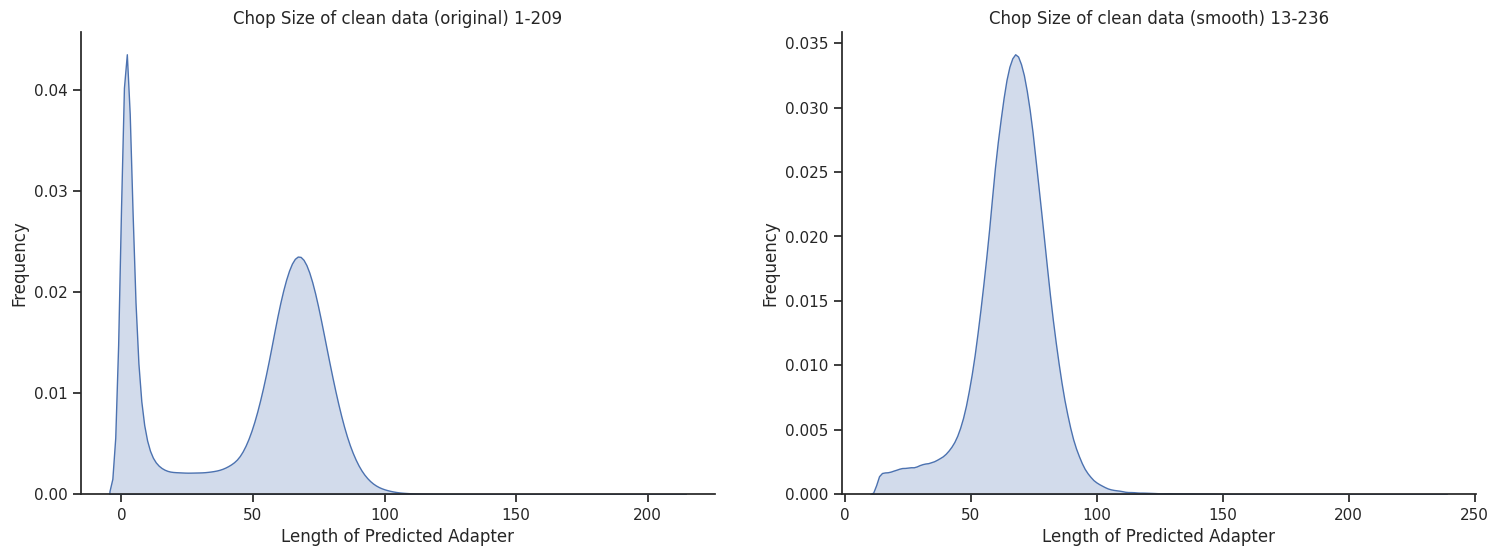

In [24]:
plot_oregion_size_data = stats.length_predicts_with_chop()
plot_sregion_size_data = stats.lenghth_smooth_predicts_with_chop()
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals2(
    plot_oregion_size_data,
    title=f"Chop Size of clean data (original) {min(plot_oregion_size_data)}-{max(plot_oregion_size_data)}",
    ax=axs[0],
)
vis_hist_for_num_of_intervals2(
    plot_sregion_size_data,
    title=f"Chop Size of clean data (smooth) {min(plot_sregion_size_data)}-{max(plot_sregion_size_data)}",
    ax=axs[1],
)

In [12]:
def vis_overlap_results(data, figsize=(9,6), log=False, context="notebook"):
    import pandas as pd

    internal_acc, terminal_acc, total_acc = get_acc(data)

    sorted_keys = [
        'sc_without_chop)',
         'terminal_chop_sc',
         'internal_chop_sc', 
         'internal_chop_sc_sa',
         'terminal_chop_nosc', 
         'terminal_chop_nosc_noblat',
         'terminal_chop_nosc_cannot_blat', 
         'internal_chop_nosc',
         'internal_chop_nosc_noblat', 
         'internal_chop_nosc_cannot_blat', 
                   'no_process',
                   'unmapped_read', 
                  
                  ]
    
    plot_df = pd.DataFrame(
        [(key, len(data.get(key, [])) ) for key in sorted_keys],
        columns=["Category", "Count"],
    )

    # sns.set_context(context)
    
    # Plotting the data
    plt.figure(figsize=figsize)  # Set the figure size
    ax = sns.barplot(x=plot_df["Category"], y=plot_df["Count"])
    ax.bar_label(ax.containers[0], fontsize=10)
    sns.despine()
    plt.xlabel("Category")  # Set the x-label
    plt.ylabel("Number of Items")  # Set the y-label
    plt.title(
        f"Count of Items in Each Category {internal_acc=:.4f} {terminal_acc=:.4f} {total_acc=:.4f}"
    )  # Set the title
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout to make room for the rotated x-labels

    plt.show()  # Display the plot
    plt.close()
    return internal_acc, terminal_acc, total_acc


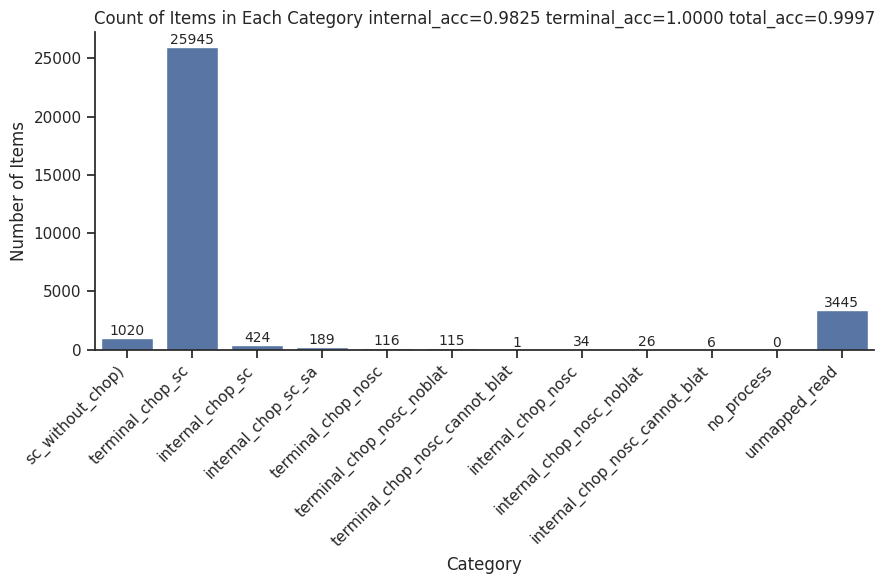

(0.982532751091703, 0.9999616284870112, 0.9996606206870545)

In [13]:
vis_overlap_results(overlap_results) # 0.4

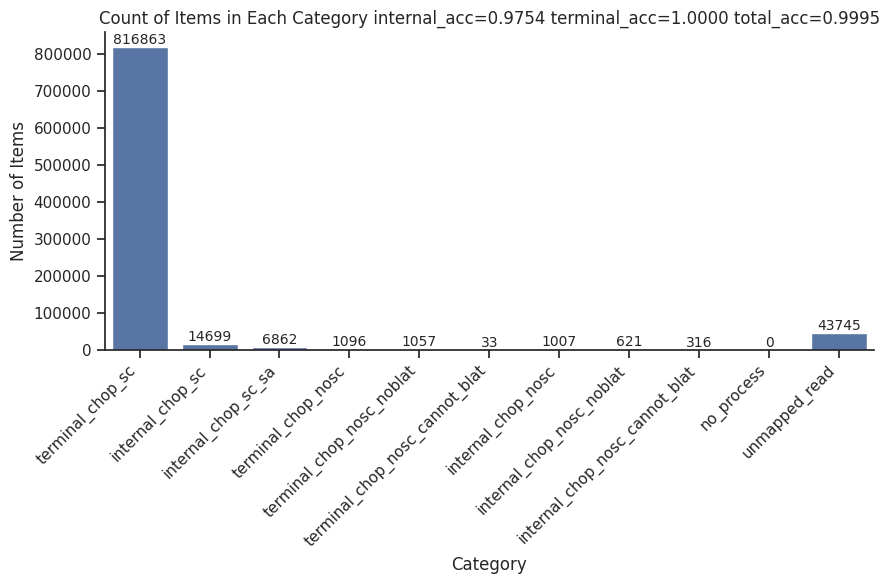

In [75]:
vis_overlap_results(overlap_results) # 0.5

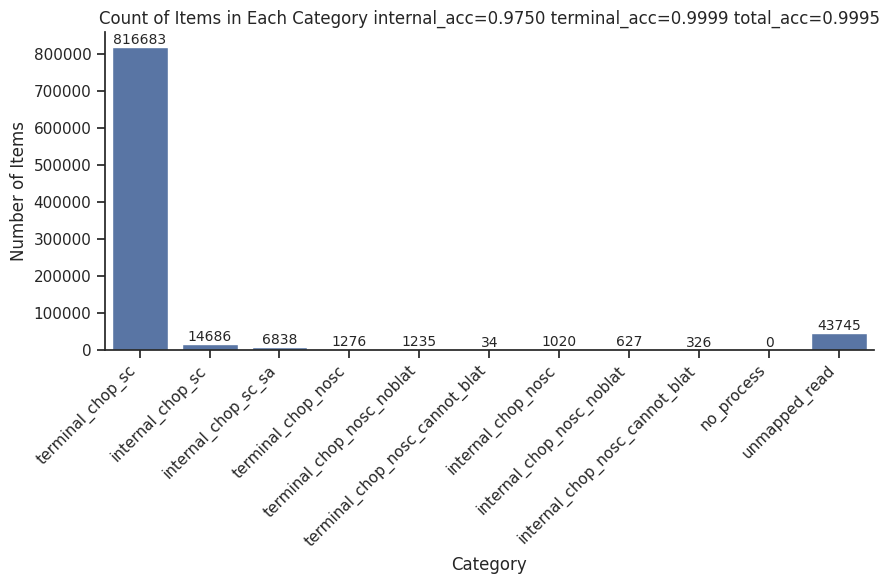

In [77]:
vis_overlap_results(overlap_results) # 0.6

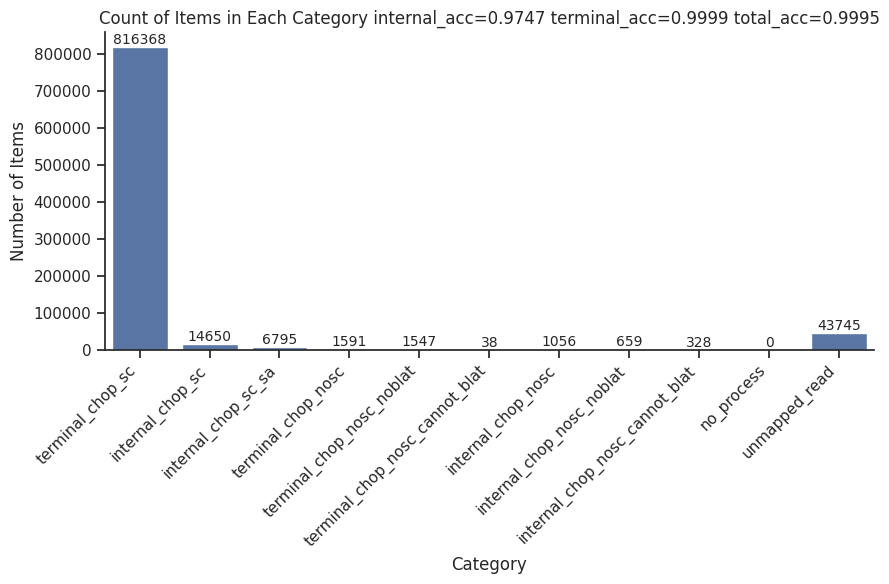

In [79]:
vis_overlap_results(overlap_results) # 0.7

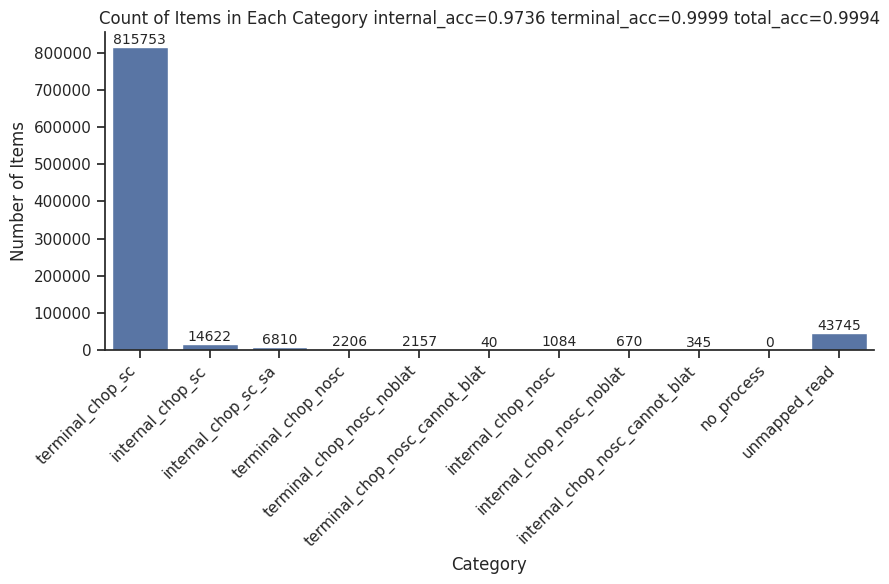

(0.9736406468865402, 0.9999400947969275, 0.9994446210408258)

In [31]:
vis_overlap_results(overlap_results) # 0.8

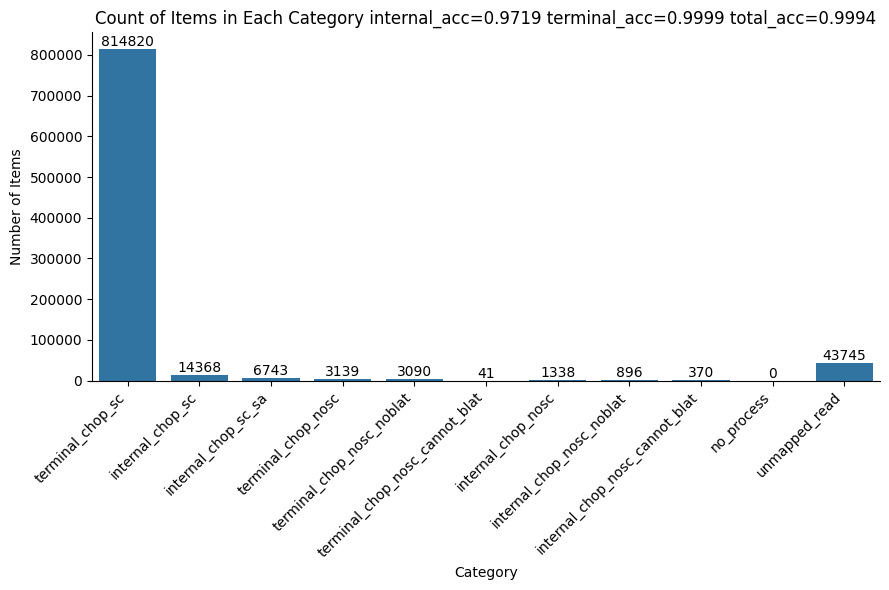

In [19]:
_= vis_overlap_results(overlap_results) # 0.9

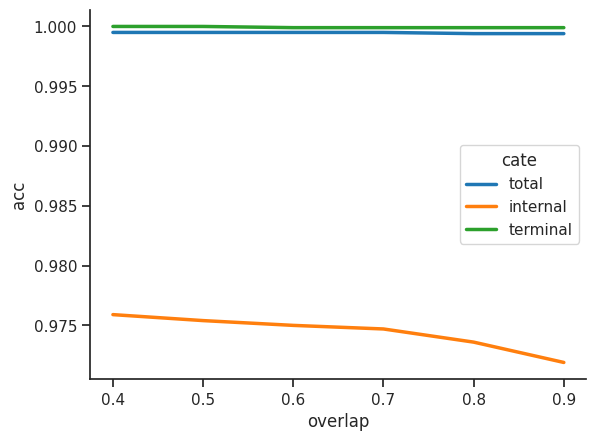

In [39]:
import pandas as pd
pdata = pd.DataFrame({
    "cate": ["total"] * 6 + ["internal"] * 6 + ["terminal"] * 6,
    "acc": [0.9995, 0.9995, 0.9995, 0.9995, 0.9994, 0.9994 ] + [0.9759,0.9754, 0.9750, 0.9747, 0.9736, 0.9719 ] + [1, 1, 0.9999, 0.9999,0.9999, 0.9999] ,
    "overlap":[0.4, 0.5, 0.6 , 0.7, 0.8, 0.9] * 3,
})
sns.set_theme(style="ticks")
sns.lineplot(data=pdata, x='overlap', y='acc', hue="cate", palette="tab10", linewidth=2.5)
sns.despine()

# Pie Chart

In [42]:
def vis_overlap_results_via_pie(data, figsize=(9,6)):
    import pandas as pd

    internal_acc, terminal_acc, total_acc = get_acc(data)

    sorted_keys = [
         'terminal_chop_sc',
         'internal_chop_sc', 
         'internal_chop_sc_sa',
         'terminal_chop_nosc', 
         'terminal_chop_nosc_noblat',
         'terminal_chop_nosc_cannot_blat', 
         'internal_chop_nosc',
         'internal_chop_nosc_noblat', 
         'internal_chop_nosc_cannot_blat', 
                   'no_process',
                   'unmapped_read', 
                  
                  ]
    
    plot_df = pd.DataFrame(
        [(key, len(data.get(key, [])) ) for key in sorted_keys],
        columns=["Category", "Count"],
    )

    # fig, ax = plt.subplots()
    
    # size = 0.3
    # vals = np.array([[60., 32.], [37., 40.], [29., 10.]])
    
    # cmap = plt.colormaps["tab20c"]
    # outer_colors = cmap(np.arange(3)*4)
    # inner_colors = cmap([1, 2, 5, 6, 9, 10])
    
    # ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
    #        wedgeprops=dict(width=size, edgecolor='w'))
    
    # ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
    #        wedgeprops=dict(width=size, edgecolor='w'))
    
    # ax.set(aspect="equal", title='Pie plot with `ax.pie`')
    # plt.show()
    return plot_df


[None, Text(0.5, 1.0, 'Pie plot with `ax.pie`')]

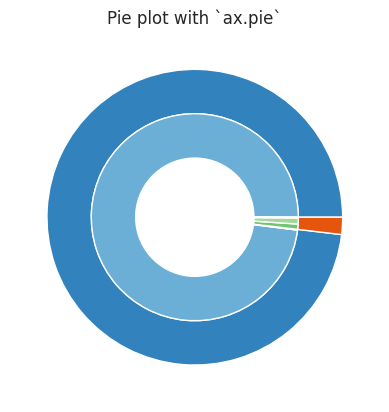

In [56]:
fig, ax = plt.subplots()

size = 0.3
# vals = np.array([[60., 32.], [37., 40.], [29., 10.]])
vals = np.array(
    [
        [
            len(overlap_results["terminal_chop_sc"]),
            0,
            len(overlap_results["terminal_chop_nosc_noblat"]),
            len(overlap_results["terminal_chop_nosc_cannot_blat"]),
        ],
        [
            len(overlap_results["internal_chop_sc_sa"]),
            len(overlap_results["internal_chop_sc"])
            - len(overlap_results["internal_chop_sc_sa"]),
            len(overlap_results["internal_chop_nosc_noblat"]),
            len(overlap_results["internal_chop_nosc_cannot_blat"]),
        ],
    ]
)

cmap = plt.colormaps["tab20c"]
outer_colors = cmap(np.arange(2)*4)
inner_colors = cmap([1, 2, 5, 6, 9, 10, 12, 13])

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')

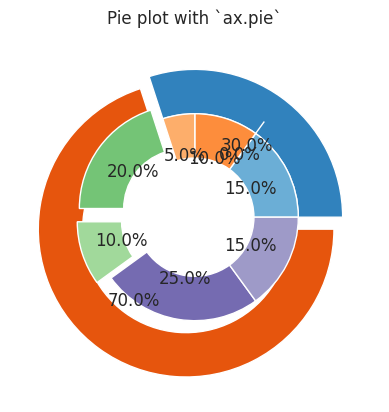

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
overlap_results = {
    "terminal_chop_sc": [1, 2, 3],
    "terminal_chop_nosc_noblat": [1, 2],
    "terminal_chop_nosc_cannot_blat": [1],
    "internal_chop_sc_sa": [1, 2, 3, 4],
    "internal_chop_sc": [1, 2, 3, 4, 5, 6],
    "internal_chop_nosc_noblat": [1, 2, 3, 4, 5],
    "internal_chop_nosc_cannot_blat": [1, 2, 3],
}

fig, ax = plt.subplots()

size = 0.3
vals = np.array(
    [
        [
            len(overlap_results["terminal_chop_sc"]),
            0,
            len(overlap_results["terminal_chop_nosc_noblat"]),
            len(overlap_results["terminal_chop_nosc_cannot_blat"]),
        ],
        [
            len(overlap_results["internal_chop_sc_sa"]),
            len(overlap_results["internal_chop_sc"])
            - len(overlap_results["internal_chop_sc_sa"]),
            len(overlap_results["internal_chop_nosc_noblat"]),
            len(overlap_results["internal_chop_nosc_cannot_blat"]),
        ],
    ]
)

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.array([0, 4]))
inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10, 12, 13]))

# Exploding internal parts
explode_outer = (0, 0.1)  # only explode the second segment
explode_inner = (0, 0.1, 0, 0, 0.1, 0.1, 0, 0)  # Exploding internal segments

# Outer pie
ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), explode=explode_outer, autopct='%1.1f%%')

# Inner pie
ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), explode=explode_inner, autopct='%1.1f%%')

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()


# Check FN

In [45]:
def summary_softclip_without_chop(
    results,
    predict,
    stats,
    rs_read,
    min_interval_size:int =13,
    dorado_with_trim=None,
    dorado_without_trim=None,
):
    read_mapping_quality = rs_read.mapping_quality
    if not rs_read.is_mapped:
        print(f"the read {predict.id} is not map")
        results["unmap_read"].append(predict.id)
        return

    seq_len = len(predict.seq)
    ls_len, rs_len = rs_read.left_softclip, rs_read.right_softclip

    if ls_len >= min_interval_size or rs_len >= min_interval_size:
        results['sc_without_chop'].append(predict.id)
        
    intervals = stats.smooth_intervals.get(predict.id, [])

    print(f"\n {seq_len=}")
    print(predict.show_info(intervals))

    txt_width = 120
    print(
        f"strand={'+' if rs_read.is_forward else '-'} {rs_read.mapping_quality=}"
    )
    print(f"cigar: {wrap_str(rs_read.cigar, txt_width)}")
    print(f"ls {ls_len}: 0-{ls_len}  {wrap_str(predict.seq[:ls_len], txt_width)}")
    print(f"rs {rs_len}: {seq_len-rs_len}-{seq_len} {wrap_str(predict.seq[seq_len-rs_len:seq_len], txt_width)}")


    if dorado_with_trim is not None or dorado_without_trim is not None:
        with_trim = dorado_with_trim[predict.id].seq
        without_trim = dorado_without_trim[predict.id].seq
        print(f"\n{predict.id} diff={len(without_trim) - len(with_trim)}")
        print(f"dorado without trim {len(without_trim)}: {without_trim}")
        print(f"dorado with trim    {len(with_trim)}   : {with_trim}")

In [15]:
%%time
rs_sam_records = deepchopper.read_bam_records_parallel(
    "/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.bam",
    8)

CPU times: user 7min 37s, sys: 1min 23s, total: 9min 1s
Wall time: 1min 17s


In [16]:
%%time
predict_path =   "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_0/predicts/0/"
all_predicts = deepchopper.load_predicts_from_batch_pts(predict_path, -100, None)

Mon May  6 00:02:50 2024 INFO Found 31250 pt files


CPU times: user 3min 39s, sys: 44.9 s, total: 4min 24s
Wall time: 1min 11s


In [32]:
def show_predict(pid, rs_sam_records, all_predicts, stats):
    read = rs_sam_records[pid] 
    pd = all_predicts[pid] 
    seq = pd.seq
    deepchopper.utils.highlight_targets(seq, stats.smooth_intervals[pid])

In [17]:
predicts_has_more_than_4 = stats.selected_predict_by_intervals(5)

In [18]:
predicts_has_more_than_4

['69c3f09f-07d9-4919-99db-c8be6db0909a',
 '1620a1ec-fdaf-47d4-8b91-bab6a192625f']

In [9]:
# pids = set(overlap_results['internal_chop_sc']) -  set(overlap_results['internal_chop_sc_sa'])
pid_without_chop = list(set(all_predicts.keys()) - set(stats.smooth_predicts_with_chop))

In [ ]:
from collections import defaultdict
tmpoop = defaultdict(list)
# pid = 'f9582789-8a72-4676-b6b2-6ef0b7689020'
# pids = predicts_has_more_than_4
for pid in overlap_results['sc_without_chop)'][:100]:
    # print(all_predicts[pid].show_info(stats.smooth_intervals[pid]))
    summary_softclip_without_chop(tmpoop, all_predicts[pid], stats, rs_sam_records[pid], dorado_with_trim=dorado_with_trim,dorado_without_trim=dorado_without_trim)


 seq_len=1102
id: 4ae116fc-be00-4603-a156-81e738205092
prediction: [1088..1094]
smooth_intervals: []
GCCAACAGACAACCCAAAGTCATTAAGCCATGAGAGTGGAATGAATCTATGAAAACTCAATGAAGACAGAACAAGAGAAA
AATCTTTCAGCCACGATGAATTGGGAGAACAAGATGTCAAATTACCATGATGTTGAGTCAAGCTTCTCAAAGCAAGAGAT
AATCAGGCTGACCTCTATTGCTGAGGACTATGAGAAAAAAGTTATTACAGAATGAGTTCATATGGAAACACTTGCAAAAC
AGAAGAATATTGAGAACATAAGTTGCCATGGAGAAATTCTCCAGTGTTTCAGCATTTCTGCTCCTTGTGGCCCCTCTCCT
ACACTCTGGCCAGAGATACCACAGTCAAACCTGGAGCCAAAAAGGACACAAAGGACATTTGACCCAAACTGCCCCAGACC
TCCAGAGGTTGGGTGACCAACTCATCTGGACTCAGACATATGAAGAAGCTCTATATAAATCCAAGACAAGCAAACCCTTG
ATGATTATTCAACCACCAAGACGAGTGCCTACAGTCAAGCTTTGAGAAAGTGTTTGCTGAAATTAAAGAAATCCAGAAAT
TGGCAGAGCAGTTTGTCCTCCTCGTCTGGTTATGAAACAACTGACAAACACCTTTCTCCTGATGGCCAGTATGTCCCCAG
GATTATGTTTGTTGACCCATCTCTGACAGTTGAGGCCGATATCACTGGAAGATATTCAAACCGTCTCTGCATGCTTACGA
ACCTGCAGATACAGCTCTGTTGCTTGACAACATGAAGAAAGCTCTTCAAGTTTGAAGACTGAATTTGTAAAGAAAATCTC
CAAGCCCCTCTGTTTGGTCAGGCCTTGAGACTTCTGAAACCAGAAGAAGTGGCAGTAGACAATCAGTGTGGGAAGCATAG
TGAACAC

In [ ]:
def vis_list_dict(data):
    import pandas as pd
    sns.set_theme(style="ticks")
    plot_df = pd.DataFrame([(key,len(data[key])) for key in data],  columns=["Category", "Count"])
    ax = sns.barplot(x=plot_df["Category"], y=plot_df["Count"])
    ax.bar_label(ax.containers[0], fontsize=10)
    sns.despine()
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout to make room for the rotated x-labels

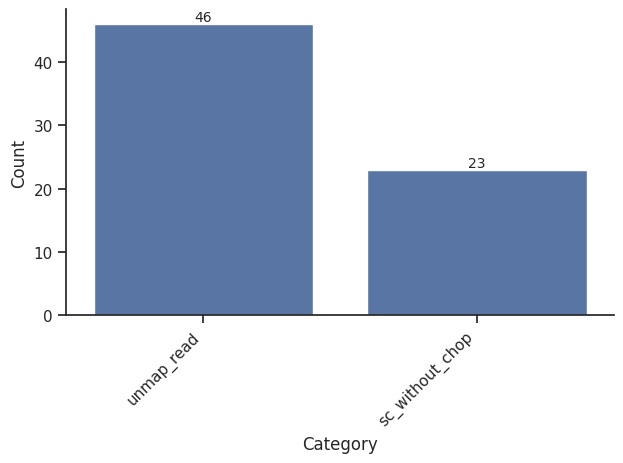

In [16]:
vis_list_dict(tmpoop)

In [39]:
from collections import defaultdict
# pid = 'f9582789-8a72-4676-b6b2-6ef0b7689020'
# pids = predicts_has_more_than_4
for pid in tmpoop['sc_without_chop']:
    # print(all_predicts[pid].show_info(stats.smooth_intervals[pid]))
    summary_softclip_without_chop(defaultdict(list), all_predicts[pid], stats, rs_sam_records[pid],    dorado_with_trim=dorado_with_trim,dorado_without_trim=dorado_without_trim)


 seq_len=1102
id: 4ae116fc-be00-4603-a156-81e738205092
prediction: [1088..1094]
smooth_intervals: []
GCCAACAGACAACCCAAAGTCATTAAGCCATGAGAGTGGAATGAATCTATGAAAACTCAATGAAGACAGAACAAGAGAAA
AATCTTTCAGCCACGATGAATTGGGAGAACAAGATGTCAAATTACCATGATGTTGAGTCAAGCTTCTCAAAGCAAGAGAT
AATCAGGCTGACCTCTATTGCTGAGGACTATGAGAAAAAAGTTATTACAGAATGAGTTCATATGGAAACACTTGCAAAAC
AGAAGAATATTGAGAACATAAGTTGCCATGGAGAAATTCTCCAGTGTTTCAGCATTTCTGCTCCTTGTGGCCCCTCTCCT
ACACTCTGGCCAGAGATACCACAGTCAAACCTGGAGCCAAAAAGGACACAAAGGACATTTGACCCAAACTGCCCCAGACC
TCCAGAGGTTGGGTGACCAACTCATCTGGACTCAGACATATGAAGAAGCTCTATATAAATCCAAGACAAGCAAACCCTTG
ATGATTATTCAACCACCAAGACGAGTGCCTACAGTCAAGCTTTGAGAAAGTGTTTGCTGAAATTAAAGAAATCCAGAAAT
TGGCAGAGCAGTTTGTCCTCCTCGTCTGGTTATGAAACAACTGACAAACACCTTTCTCCTGATGGCCAGTATGTCCCCAG
GATTATGTTTGTTGACCCATCTCTGACAGTTGAGGCCGATATCACTGGAAGATATTCAAACCGTCTCTGCATGCTTACGA
ACCTGCAGATACAGCTCTGTTGCTTGACAACATGAAGAAAGCTCTTCAAGTTTGAAGACTGAATTTGTAAAGAAAATCTC
CAAGCCCCTCTGTTTGGTCAGGCCTTGAGACTTCTGAAACCAGAAGAAGTGGCAGTAGACAATCAGTGTGGGAAGCATAG
TGAACAC

In [ ]:
# %%time
# sam_records = collect_sam_records("/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.bam")

In [ ]:
# len(sam_records)

In [ ]:
%%time
rs_sam_records = deepchopper.read_bam_records_parallel(
    "/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.bam"
)

In [ ]:
len(rs_sam_records)

In [ ]:
test_chunks = [
    Path("/projects/b1171/ylk4626/project/DeepChopper/tests/data/eval/chunk0"),
    Path("/projects/b1171/ylk4626/project/DeepChopper/tests/data/eval/chunk1"),
]

In [ ]:
fq_records = collect_fq_records(
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.fastq"
    )
)

In [ ]:
len(fq_records)

In [26]:
## VCaP
hyena_results = [
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_0/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_1/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_2/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_3/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_4/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_5/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_6/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_7/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_8/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_9/predicts/0/"
    ),
]


max_batches = 100
all_predicts = deepchopper.load_predicts_from_batch_pts(hyena_results[0], -100, max_batches)

Sun Apr 28 00:20:55 2024 INFO Found 31250 pt files
Sun Apr 28 00:20:55 2024 INFO only load first 100 pt files


In [27]:
len(all_predicts)

3200

In [28]:
%%time
pystats = deepchopper.py_collect_statistics_for_predicts_parallel(
    list(all_predicts.values()),
    smooth_window_size=21,
    min_interval_size=10,
    approved_interval_number=10,
    internal_threshold=INTERNAL_THRESHOLD,
    ploya_threshold=3,
)
stats

CPU times: user 2.04 s, sys: 3.76 ms, total: 2.04 s
Wall time: 36.4 ms


StatResult(total_predicts: 2996,  predicts_with_chop: 2791, smooth_predicts_with_chop: 2743,
                        smooth_internal_predicts: 51, total_truncated: 0, smooth_only_one: 2700,
                        smooth_ploya_only_one: 2202)

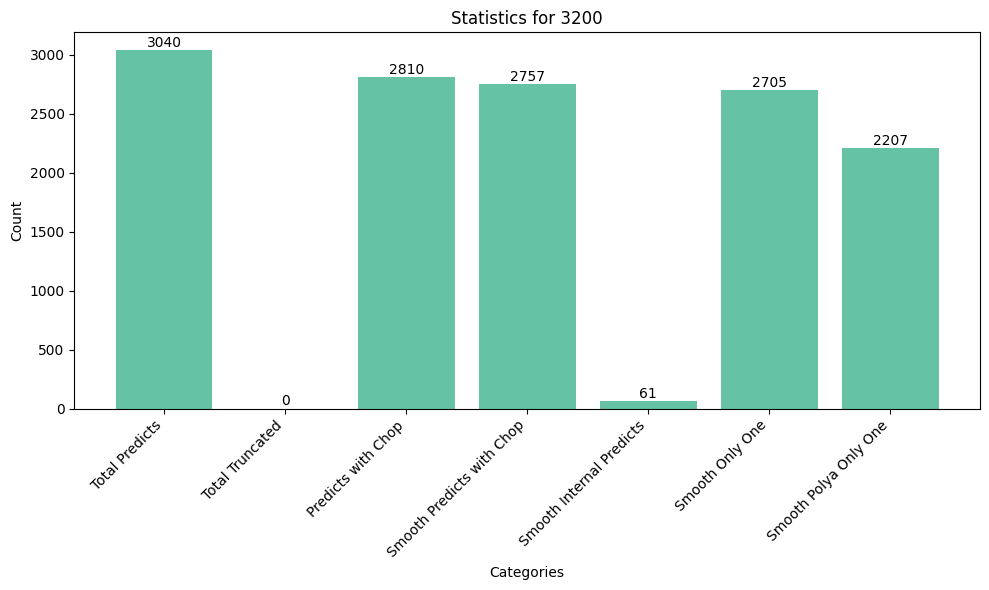

In [29]:
vis_stats(pystats, len(all_predicts))

In [ ]:
print(
    all_predicts[stats.predicts_with_chop[0]].show_info(
        stats.smooth_intervals[stats.predicts_with_chop[0]]
    )
)

In [ ]:
original_prediction_number = stats.number_predicts_with_chop(all_predicts)
smooth_prediction_number = stats.number_smooth_predicts_with_chop()

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals(original_prediction_number, title="Original Intervals", ax=axs[0])
vis_hist_for_num_of_intervals(smooth_prediction_number, title="Smooth Intervals", ax=axs[1])

In [ ]:
len(stats.smooth_only_one_with_ploya)

In [ ]:
plot_oregion_size_data = stats.length_predicts_with_chop(all_predicts)
plot_sregion_size_data = stats.lenghth_smooth_predicts_with_chop()
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals(
    plot_oregion_size_data,
    title=f"Chop Size of clean data (original) {min(plot_oregion_size_data)}-{max(plot_oregion_size_data)}",
    ax=axs[0],
)
vis_hist_for_num_of_intervals(
    plot_sregion_size_data,
    title=f"Chop Size of clean data (smooth) {min(plot_sregion_size_data)}-{max(plot_sregion_size_data)}",
    ax=axs[1],
)

In [ ]:
total_predicts = len(stats.smooth_predicts_with_chop)
overlap_results = defaultdict(list)
idx = 0

for p in stats.smoo:
    if len(stats.smooth_intervals[p]) >= 3:
        idx += 1
        if idx > 100:
            break

        verify_result_with_sam_records_rs(
            overlap_results, all_predicts[p], stats, rs_sam_records[p]
        )

In [ ]:
vis_overlap_results(overlap_results)

In [ ]:
with open(f"overlap_result_{max_batches}.json", "w") as outfile:
    json.dump(overlap_results, outfile, indent=4, sort_keys=False)

In [ ]:
selected = set(overlap_results["internal_chop_nosc"]) - set(
    overlap_results["internal_chop_nosc_noblat"]
    + overlap_results["internal_chop_nosc_cannot_blat"]
)

for value in selected:
    pd = all_predicts[value]

    verify_result_with_sam_records_rs(
        defaultdict(list),
        pd,
        stats,
        rs_sam_records[value],
        internal_threshold=INTERNAL_THRESHOLD,  # change to 0.9
        overlap_threshold=OVERLAP_THRESHOLD,
        blat_threshold=BLAT_THRESHOLD,
        min_mapping_quality=MIN_MAPPING_QUALITY,
    )

In [ ]:
# %%time
# import json
# from joblib import Parallel, delayed
# # # Run the processing in parallel and collect all results
# results_list = Parallel(n_jobs=1)(
#     delayed(verify_result_with_sam_records_for_parallel)(all_predicts[p].seq,
#                                                          all_predicts[p].id,
#                                                          stats.smooth_intervals,
#                                                          rs_sam_records[p].is_mapped,
#                                                          rs_sam_records[p].mapping_quality ,
#                                                          rs_sam_records[p].left_softclip,
#                                                          rs_sam_records[p].right_softclip,
#                                                          ) for p in stats.smooth_predicts_with_chop)
# overlap_results = merge_results(results_list)

# with open("overlap_result.json", "w") as outfile:
#     json.dump(overlap_results, outfile, indent=4, sort_keys=False)

In [ ]:
for pid, p in all_predicts.items():
    p.qual = fq_records[p.id].qual

In [ ]:
ps = stats.smooth_predicts_with_chop
len(ps)

for p in ps[:1000]:
    pd = all_predicts[p]
    # show_sam_record(pd, stats, sam_records)
    sreg = stats.smooth_intervals.get(p, [])
    if len(sreg) > 2:
        print("\n")
        print(pd.show_info(sreg))

In [ ]:
p = stats.predicts_with_chop[0]
vis_qual_static(
    all_predicts[p], stats.smooth_intervals[p][0][0] - 10, stats.smooth_intervals[p][0][1] + 10
)

In [ ]:
len(stats.smooth_only_one)

In [ ]:
len(stats.smooth_predicts_with_chop)

In [ ]:
def show_examples(predcit_ids, all_predicts, stats):
    for predict_id in predcit_ids:
        predict = all_predicts[predict_id]

        smooth_regs = stats.smooth_intervals.get(predict_id, [])
        print(predict.show_info(smooth_regs))

In [ ]:
show_examples(
    set(stats.smooth_predicts_with_chop) - set(stats.smooth_only_one), all_predicts, stats
)

In [ ]:
overlap_results.keys()

In [ ]:
# from collections import defaultdict
# ps  = stats.smooth_predicts_with_chop

# overlap_results  = defaultdict(list)
# # ps = set(os) - set(stats.smooth_internal_predicts)
# for p in ps:
#     pd = all_predicts[p]
#     # sreg = stats.smooth_intervals.get(p, [])
#     # if len(sreg) > 2:
#         # show_sam_record(pd, stats, sam_records)
#         # print("\n")
#         # print(pd.show_info(sreg))s

#     verify_result_with_sam_records(
#     overlap_results,
#     pd,
#     stats,
#     sam_records,
#     internal_threshold = 0.85,
#     overlap_threshold  = 0.4,
#     blat_threshold  = 0.9,
#     min_mapping_quality = 0)

In [ ]:
stats